# 3. Part of Speech (POS) tagging

## Objetivo

- Implementar un modelo de etiquetado automático usando modelos estructurados
    - Uso de Conditional Random Fields
- Los alumnæs contrastarán entre modelos discriminativos (*HMM*) y condicionales (*CRFs*) para generación automática de secuencias de etiquetas

## Recordando POS

- Etiquetas que hacen explicita la funcion gramatical de las palabras en una oración
- Determina la función de la palabra dentro la oración (por ello se le llama Partes del Discurso)
- Permiten el desarrollo de herramientas de NLP más avanzadas

## El primer acercamiento: Hidden Markov Models (HMM)

$p(\overrightarrow{y},\overrightarrow{x}) = \displaystyle\prod_{i=1}^{n} p(y_i|y_{i-1}) ⋅ p(x_i|y_i)$

Donde:
- $\overrightarrow{y} = secuencia\ de\ etiquetas\ POS$
- $\overrightarrow{x} = secuencia\ de\ palabras$

## Suposición de Markov

> "The probability of a particular state is dependent only on the previous state"

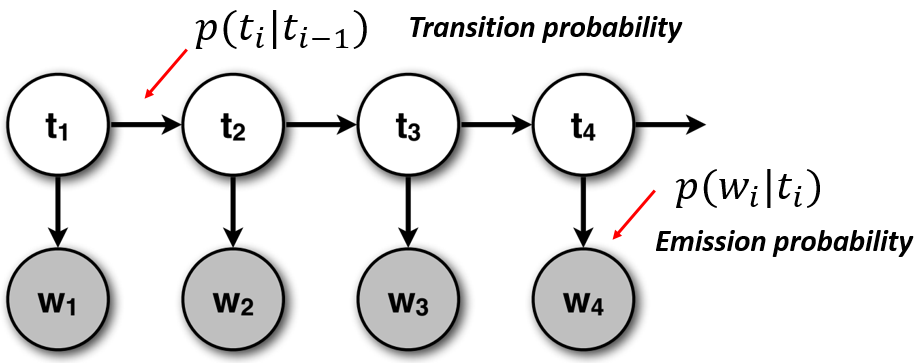

Tomada de https://www.davidsbatista.net/blog/2017/11/11/HHM_and_Naive_Bayes/

### ¿Limitaciones?

- Cada estado depende exclusivamente de su predecesor inmediato
    - Dependencias limitadas
- Cada observación depende exclusivamente del estado actual
- Probabilidades estáticas
    - Ejemplo, si veo un par de tags `(V) -> (S)` no importa si esta al inicio, en medio o al final de la oración la probabilidad siempre será la misma

![](https://3.bp.blogspot.com/-pPGGqs462yw/T1ol64kj9uI/AAAAAAAAAKI/CDCiH1IJodE/w1200-h630-p-k-nu/patricio.jpg)

## Sobrepasando las fronteras: Conditional Random Fields

### Características

- Modelo de gráficas **no dirigido**. Generaliza los *HMM*
    - Adiós a la *Markov assuption*
    - Podemos tener cualquier dependencia que queramos entre nodos
    - Nos enfocaremos en un tipo en concreto: *LinearChain-CRFs* ¡¿Por?!
![power.jpg](https://i.kym-cdn.com/entries/icons/original/000/032/676/Unlimited_Power_Banner.jpg)

- Modela la probabilidad **condicional** $P(Y|X)$
    - Modelo discriminativo
    - No importa como fueron generados los datos
    - Probabilidad de un estado oculto dada **toda** la secuecia de entrada
![homer](https://media.tenor.com/ul0qAKNUm2kAAAAd/hiding-meme.gif)

- Captura mayor **número de dependencias** entre las palabras y captura más características
    - Estas se definen en las *feature functions* 🙀
- El entrenamiento se realiza aplicando gradiente decendente y optimización con algoritmos como [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS)
![gradient-descent](https://iameo.github.io/images/gradient-descent-400.gif)


### Linear-chain CRFs

$P(\overrightarrow{y}|\overrightarrow{x}) = \frac{1}{Z} \displaystyle\prod_{i=1}^N exp\{w^T ⋅ \phi(y_{i-1}, y_i, \overrightarrow{x}, i)\}$

Donde:
- $\overrightarrow{y}$ = Etiquetas POS
- $\overrightarrow{x}$ = Palabras en una oración
- $w^T$ = Vector de pesos a aprender
- $\phi$ = Vector de *Features*
    - Calculado con base en un conjunto de *feature functions*
- $i$ = la posición actual en la oración
- $Z$ = factor de normalización

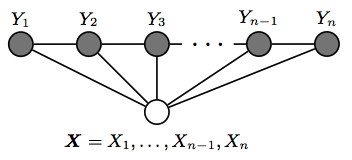

Tomado de https://www.davidsbatista.net/blog/2017/11/13/Conditional_Random_Fields/

### Feature functions $\phi(y_{i-1}, y_i, \overrightarrow{x}, i)$

- Parte fundamental de los CRFs
- Cuatro argumentos:
    - Todos los datos observables $\overrightarrow{x}$ (conectar $x$ con cualquier $y$)
    - El estado oculto anterior $y_{i-1}$
    - El estado oculto actual $y_i$
    - El index del timestamp $i$
        - Cada feature list puede tener diferentes formas

- Aqui es donde esta la flexibilidad del modelo
- Tantas features como querramos, las que consideremos que pueden ayudar a que el modelo tenga un mejor desempeño
    - Intimamente ligadas a la lengua. Para mejor desempeño se debe hacer un análisis de sus características.
- Ejemplo:

```python
[
    "word.lower()",
    "EOS",
    "BOS",
    "postag",
    "pre-word",
    "nxt-word",
    "word-position",
    ...
]
```

### Implementación

#### 0. Instalación de dependencias

In [1]:
!pip install -U sklearn-crfsuite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 6.3 MB/s eta 0:00:00


#### 1. Preparación de datos

In [2]:
import nltk
from nltk.corpus import cess_esp
from sklearn_crfsuite import CRF
from sklearn.model_selection import train_test_split

# Load the Spanish POS tagged corpus
nltk.download("cess_esp")
corpus = cess_esp.tagged_sents()

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Unzipping corpora/cess_esp.zip.


In [3]:
len(corpus)

6030

In [4]:
import requests

def get_tags_map():
    tags_raw = requests.get("https://gist.githubusercontent.com/vitojph/39c52c709a9aff2d1d24588aba7f8155/raw/af2d83bc4c2a7e2e6dbb01bd0a10a23a3a21a551/universal_tagset-ES.map").text.split("\n")
    tags_map = {line.split("\t")[0].lower(): line.split("\t")[1] for line in tags_raw}
    return tags_map

def map_tag(tag: str, tags_map=get_tags_map()) -> str:
    return tags_map.get(tag.lower(), "N/F")

In [5]:
corpus[0]

[('El', 'da0ms0'),
 ('grupo', 'ncms000'),
 ('estatal', 'aq0cs0'),
 ('Electricité_de_France', 'np00000'),
 ('-Fpa-', 'Fpa'),
 ('EDF', 'np00000'),
 ('-Fpt-', 'Fpt'),
 ('anunció', 'vmis3s0'),
 ('hoy', 'rg'),
 (',', 'Fc'),
 ('jueves', 'W'),
 (',', 'Fc'),
 ('la', 'da0fs0'),
 ('compra', 'ncfs000'),
 ('del', 'spcms'),
 ('51_por_ciento', 'Zp'),
 ('de', 'sps00'),
 ('la', 'da0fs0'),
 ('empresa', 'ncfs000'),
 ('mexicana', 'aq0fs0'),
 ('Electricidad_Águila_de_Altamira', 'np00000'),
 ('-Fpa-', 'Fpa'),
 ('EAA', 'np00000'),
 ('-Fpt-', 'Fpt'),
 (',', 'Fc'),
 ('creada', 'aq0fsp'),
 ('por', 'sps00'),
 ('el', 'da0ms0'),
 ('japonés', 'aq0ms0'),
 ('Mitsubishi_Corporation', 'np00000'),
 ('para', 'sps00'),
 ('poner_en_marcha', 'vmn0000'),
 ('una', 'di0fs0'),
 ('central', 'ncfs000'),
 ('de', 'sps00'),
 ('gas', 'ncms000'),
 ('de', 'sps00'),
 ('495', 'Z'),
 ('megavatios', 'ncmp000'),
 ('.', 'Fp')]

In [6]:
for word, tag in corpus[0]:
    print(word, "-->" ,map_tag(tag))

El --> DET
grupo --> NOUN
estatal --> ADJ
Electricité_de_France --> NOUN
-Fpa- --> .
EDF --> NOUN
-Fpt- --> .
anunció --> VERB
hoy --> ADV
, --> .
jueves --> NOUN
, --> .
la --> DET
compra --> NOUN
del --> ADP
51_por_ciento --> NUM
de --> ADP
la --> DET
empresa --> NOUN
mexicana --> ADJ
Electricidad_Águila_de_Altamira --> NOUN
-Fpa- --> .
EAA --> NOUN
-Fpt- --> .
, --> .
creada --> ADJ
por --> ADP
el --> DET
japonés --> ADJ
Mitsubishi_Corporation --> NOUN
para --> ADP
poner_en_marcha --> VERB
una --> DET
central --> NOUN
de --> ADP
gas --> NOUN
de --> ADP
495 --> NUM
megavatios --> NOUN
. --> .


#### Feature functions

In [7]:
def word_to_features(sent, i):
    word = sent[i][0]
    features = {
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            'prev_word.lower()': prev_word.lower(),
            'prev_word.istitle()': prev_word.istitle(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    return features

# Extract features and labels
def sent_to_features(sent):
    return [word_to_features(sent, i) for i in range(len(sent))]

def sent_to_labels(sent):
    return [label for token, label in sent]

In [8]:
# Prepare data for CRF
X = [[word_to_features(sent, i) for i in range(len(sent))] for sent in corpus]
y = [[map_tag(pos) for _, pos in sent] for sent in corpus]

In [9]:
X[0]

[{'word.lower()': 'el',
  'word[-3:]': 'El',
  'word[-2:]': 'El',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'BOS': True},
 {'word.lower()': 'grupo',
  'word[-3:]': 'upo',
  'word[-2:]': 'po',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'el',
  'prev_word.istitle()': True},
 {'word.lower()': 'estatal',
  'word[-3:]': 'tal',
  'word[-2:]': 'al',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'grupo',
  'prev_word.istitle()': False},
 {'word.lower()': 'electricité_de_france',
  'word[-3:]': 'nce',
  'word[-2:]': 'ce',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'estatal',
  'prev_word.istitle()': False},
 {'word.lower()': '-fpa-',
  'word[-3:]': 'pa-',
  'word[-2:]': 'a-',
  'word.isupper()': False,
  'word.istitle()': True,
  'word.isdigit()': False,
  'prev_word.lower()': '

In [10]:
y[0]

['DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 'VERB',
 'ADV',
 '.',
 'NOUN',
 '.',
 'DET',
 'NOUN',
 'ADP',
 'NUM',
 'ADP',
 'DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 '.',
 'ADJ',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADP',
 'NUM',
 'NOUN',
 '.']

In [ ]:
for feature in X[0]:
    print(feature)

{'word.lower()': 'el', 'word[-3:]': 'El', 'word[-2:]': 'El', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'BOS': True}
{'word.lower()': 'grupo', 'word[-3:]': 'upo', 'word[-2:]': 'po', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'prev_word.lower()': 'el', 'prev_word.istitle()': True}
{'word.lower()': 'estatal', 'word[-3:]': 'tal', 'word[-2:]': 'al', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'prev_word.lower()': 'grupo', 'prev_word.istitle()': False}
{'word.lower()': 'electricité_de_france', 'word[-3:]': 'nce', 'word[-2:]': 'ce', 'word.isupper()': False, 'word.istitle()': False, 'word.isdigit()': False, 'prev_word.lower()': 'estatal', 'prev_word.istitle()': False}
{'word.lower()': '-fpa-', 'word[-3:]': 'pa-', 'word[-2:]': 'a-', 'word.isupper()': False, 'word.istitle()': True, 'word.isdigit()': False, 'prev_word.lower()': 'electricité_de_france', 'prev_word.istitle()': False}
{'word.lower()': 'edf

In [ ]:
y[0]

['DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 'VERB',
 'ADV',
 '.',
 'NOUN',
 '.',
 'DET',
 'NOUN',
 'ADP',
 'NUM',
 'ADP',
 'DET',
 'NOUN',
 'ADJ',
 'NOUN',
 '.',
 'NOUN',
 '.',
 '.',
 'ADJ',
 'ADP',
 'DET',
 'ADJ',
 'NOUN',
 'ADP',
 'VERB',
 'DET',
 'NOUN',
 'ADP',
 'NOUN',
 'ADP',
 'NUM',
 'NOUN',
 '.']

In [11]:
len(X[0]) == len(y[0])

True

In [12]:
 # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train[0]

[{'word.lower()': 'sin_embargo',
  'word[-3:]': 'rgo',
  'word[-2:]': 'go',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'BOS': True},
 {'word.lower()': ',',
  'word[-3:]': ',',
  'word[-2:]': ',',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'sin_embargo',
  'prev_word.istitle()': False},
 {'word.lower()': 'el',
  'word[-3:]': 'el',
  'word[-2:]': 'el',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': ',',
  'prev_word.istitle()': False},
 {'word.lower()': 'hecho',
  'word[-3:]': 'cho',
  'word[-2:]': 'ho',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'el',
  'prev_word.istitle()': False},
 {'word.lower()': 'más',
  'word[-3:]': 'más',
  'word[-2:]': 'ás',
  'word.isupper()': False,
  'word.istitle()': False,
  'word.isdigit()': False,
  'prev_word.lower()': 'hecho',
  'prev_wo

In [14]:
print(y_train[0])

['CONJ', '.', 'DET', 'NOUN', 'ADV', 'ADJ', 'ADV', 'VERB', 'DET', 'NOUN', 'ADJ', 'ADP', 'NOUN', 'ADP', 'NOUN', '.', 'PRON', 'NOUN', 'VERB', 'ADJ', 'CONJ', 'DET', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', '.', 'ADP', 'DET', 'PRON', 'ADP', 'DET', 'NOUN', 'DET', 'NOUN', 'VERB', 'VERB', 'NOUN', 'ADJ', 'CONJ', 'ADJ', '.']


#### Entrenamiento del modelo

In [15]:
from inspect import Attribute
from sklearn_crfsuite import CRF
# Initialize and train the CRF tagger: https://sklearn-crfsuite.readthedocs.io/en/latest/api.html
crf = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100, all_possible_transitions=True, verbose=True)
try:
    crf.fit(X_train, y_train)
except AttributeError as e:
    print(e)

loading training data to CRFsuite: 100%|██████████| 4824/4824 [00:01<00:00, 2646.99it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 64668
Seconds required: 0.432

L-BFGS optimization
c1: 0.100000
c2: 0.100000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.48  loss=328686.77 active=63814 feature_norm=1.00
Iter 2   time=0.49  loss=196072.08 active=63991 feature_norm=12.47
Iter 3   time=0.24  loss=124354.85 active=62140 feature_norm=13.74
Iter 4   time=0.25  loss=108650.95 active=63508 feature_norm=14.66
Iter 5   time=0.24  loss=92563.55 active=63135 feature_norm=16.86
Iter 6   time=0.25  loss=76173.95 active=62372 feature_norm=21.53
Iter 7   time=0.20  loss=64294.34 active=59276 feature_norm=28.27
Iter 8   time=0.15  loss=55931.45 active=58299 feature_norm=32.76
Iter 9   time=0.16  loss=49529.47 active=55638 feature_norm=39.17
It

In [16]:
from sklearn.metrics import classification_report
y_pred = crf.predict(X_test)

# Flatten the true and predicted labels
y_test_flat = [label for sent_labels in y_test for label in sent_labels]
y_pred_flat = [label for sent_labels in y_pred for label in sent_labels]

# Evaluate the model
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

           .       1.00      1.00      1.00      4820
         ADJ       0.90      0.90      0.90      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.93      0.95      1473
        CONJ       0.96      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.96      0.97      0.96      9005
         NUM       0.90      0.81      0.85       400
        PRON       0.95      0.94      0.94      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      0.75      0.86         4

    accuracy                           0.97     38876
   macro avg       0.96      0.93      0.94     38876
weighted avg       0.97      0.97      0.97     38876



### Metricas

#### Confusion Matrix (binaria)

Es una forma tabular de vizualizar el desempeño de un modelo de *Machine Learning (ML)*. En las columnas tenemos la cuenta de etiquetas predichas mientras que en las filas tenemos la cuenta de las etiquetas reales (o viceversa)

![](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/3_confusion_matrix.png?ssl=1)

- **TP:** Etiquetas correctamente predichas como positivas. Ej: Se etiqueto un correo como spam y era spam
- **FP:** Etiquetas incorrectamente predichas. Ej: Se etiqueto un correo como spam y NO era spam
- **TN:** Etiquetas correctamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era no spam
- **FN:** Etiquetas incorrectamente predichas como negativas. Ej: Se etiqueto un correo como no spam y era spam

#### Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

Es una de las métricas más sencillas usadas en *ML*. Define que tan exacto es el modelo. Por ejemplo, si de 100 etiquetas el modelo acerto en 90 tendremos un accuracy de 0.90 o 90%

In [17]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred_flat, y_test_flat))

0.9719621360222245


#### Precision = $\frac{TP}{TP + FP}$

Indica la relación entre las predicciones positivas correctas (SPAM es SPAM) con el total de predicciones de la clase sin importar si fueron correctas o no (Todo lo que fue marcado como SPAM correctamente con todo lo que fue marcado como SPAM incorrectamente). *De los correos etiquetados como SPAM cuandos fueron efectivamente SPAM*

In [18]:
from sklearn.metrics import precision_score
print(precision_score(y_pred_flat, y_test_flat, average="macro"))

0.9298934606629448


#### Recall = $\frac{TP}{TP + FN}$

Indica la relacion entre las predicciones positivas correctas con el total de predicciones incorrectas de otras clases (Todo lo que no se marco como SPAM cuando si era SPAM). *Todos los correos que en realidad eran SPAM*

In [19]:
from sklearn.metrics import recall_score
print(recall_score(y_pred_flat, y_test_flat, average="macro"))

0.963350812126708


#### F1-score = $\frac{2PR}{P + R}$

Es el promedio ponderado entre *precision* y *recall*. Toma en cuenta tanto los FP como los FN.

In [20]:
from sklearn.metrics import f1_score
print(f1_score(y_pred_flat, y_test_flat, average="macro"))

0.9447199276103851


#### Confussion Matrix para multi-class

Confusion matrix:
[[4818    1    0    0    0    0    0    1    0    0    0]
 [   0 2415    0   18    0    7  205    0    2   28    0]
 [   0    0 6565    1    7    0    3    0    0    1    0]
 [   0   33    7 1373   18    1   28    0    3   10    0]
 [   0    0    8    5 2079    0    1    0   55    1    0]
 [   0   11    0    3    0 5511    9    0   27    2    0]
 [   0  181    3   14    2    5 8704   33    4   59    0]
 [   0    1    0    0    0    6   68  323    0    2    0]
 [   0    3    0    7   49   29   13    0 1600    4    0]
 [   0   49    3    4    0    0   52    0    2 4395    0]
 [   0    1    0    0    0    0    0    0    0    0    3]]


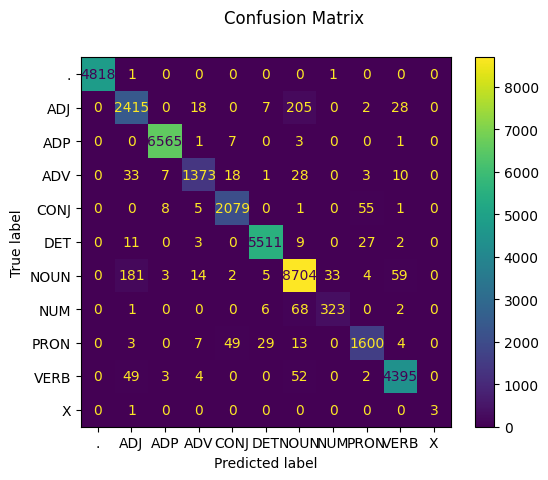

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test_flat, y_pred_flat)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")

#### Precision, recall y F1-score para multiclass


- Macro avg: Calculo de la metrica de cada clase para despues se obtener el average no ponderado
- Weighted avg : Calculo de las metricas de cada clase y obteniendo si average ponderado con la cantidad de instancias de cada clase (*support*)
    - útil para datasets no balanceados

In [22]:
report = classification_report(y_true=y_test_flat, y_pred=y_pred_flat)
print(report)

              precision    recall  f1-score   support

           .       1.00      1.00      1.00      4820
         ADJ       0.90      0.90      0.90      2675
         ADP       1.00      1.00      1.00      6577
         ADV       0.96      0.93      0.95      1473
        CONJ       0.96      0.97      0.97      2149
         DET       0.99      0.99      0.99      5563
        NOUN       0.96      0.97      0.96      9005
         NUM       0.90      0.81      0.85       400
        PRON       0.95      0.94      0.94      1705
        VERB       0.98      0.98      0.98      4505
           X       1.00      0.75      0.86         4

    accuracy                           0.97     38876
   macro avg       0.96      0.93      0.94     38876
weighted avg       0.97      0.97      0.97     38876



### Práctica 3: Implementación de un etiquetador POS usando CRFs

**Fecha de entrega 25 de Septiembre 9:00am**

- Implementar un etiquetador POS para el idioma otomí
    - Escenario retador de bajos recursos lingüísticos (low-resources)
    - Considerar que las feature functions **deben** cambiar (van acorde a la lengua)
    - Pueden usar bibliotecas conocidas para la implementación
- Comparar los resultados obtenidos con el CRF visto en clase
    - Reportar accurary, precision, recall y F1-score
    - Mostrar un ejemplo de oracion etiquetada (Debe ser una oracion del conjunto de pruebas). Formato libre

#### Extra
- Hacer un análisis breve de los resultados
    - ¿Qué diferencias encuentran entre trabajar con textos en español y en Otomí?
    - ¿Se obtuvieron buenos o malos resultados? ¿Porqué?


### Corpus

- [DESCARGA 📕](https://drive.google.com/file/d/1ihr6gixN7NUkeq9MswJIdXV5Rda-hRFI/view?usp=drive_link)
- Oraciones del Otomí de Toluca, variante de la región San Andrés Cuexcontitlan
- Glosado manual por [Dr. Victor Mijangos de la Cruz](https://sites.google.com/site/victormijangoscruz/?pli=1)

#### Estructura de cada línea

```
[[[CHUNK, GLOSS], [CHUNK, GLOSS],..., POS],...]
  |---------------------------------|
                WORD
```

##### Ejemplo

```python
[
    [['por', 'stem'], 'obl'],
    #   |      |        |
    # CHUNK, GLOSS,    POS
    [['eso', 'stem'], 'obl'],
    [
        ['n', 'psd'],
        ['ga', '3.pls'],
        ['má', 'ctrf'],
        ["'u̱n", 'stem'],
        ['gí', '1.obj'], 'v'] # ngamá'u̱ngí
]
```

##### Etiquetas y su significado

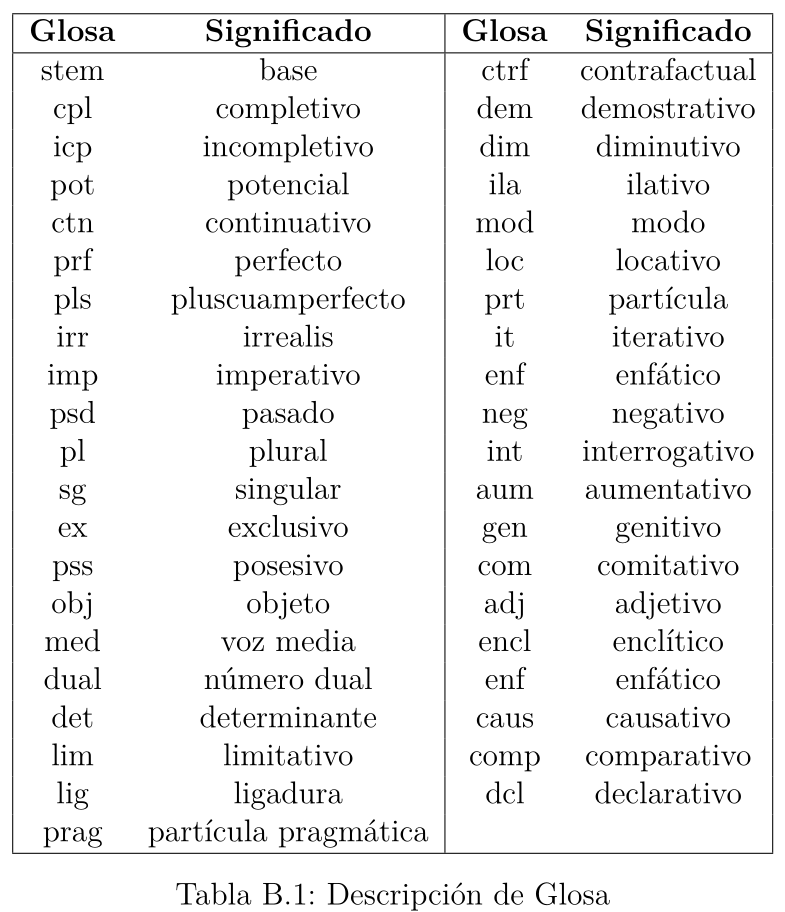

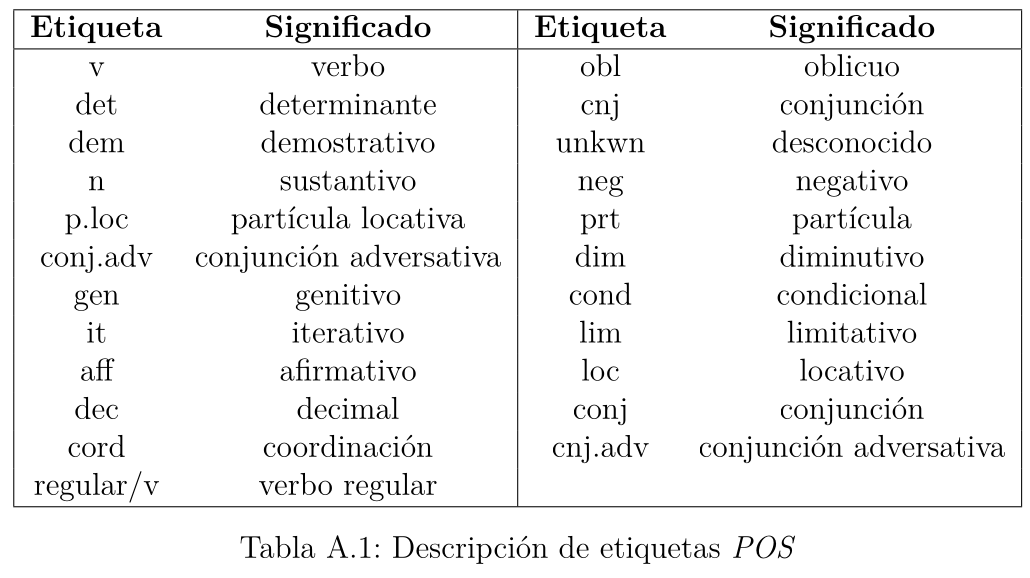

## Referencias

- https://towardsdatascience.com/pos-tagging-using-crfs-ea430c5fb78b
- https://www.davidsbatista.net/blog/2017/11/13/Conditional_Random_Fields/- ⭐
- [Conditional Random Fields : Data Science Concepts](https://www.youtube.com/watch?v=rI3DQS0P2fk) 📹
- [Multi-label metrics](https://www.kaggle.com/code/nkitgupta/evaluation-metrics-for-multi-class-classification) 📊